## Decision Tree Model

Import the necessary libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

Load the dataset

In [2]:
meps_data = pd.read_csv('datasets/integrated_data.csv')
meps_data.head()

,Unnamed: 0,Person.ID,Drug,Quantity,Strength,Day_Supply,Daily_Frequency,Daily_Dosage,Year,Age,Sex,Ethnicity,Race,Personal_income,Family_income,Poverty_category,Can.t_get_PMED,Insurance_coverage,PMED_insurance_coverage,Concentration
0,1,40001101,desoximetasone,60.0,50000.0,30.000000,2.000000,100000.000000,2014,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0,0.000805
1,2,40001101,desoximetasone,60.0,50000.0,30.000000,2.000000,100000.000000,2014,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0,0.000805
2,3,41807102,desoximetasone,60.0,250000.0,25.777778,2.327586,581896.551724,2014,30.0,2.0,4.0,4.0,0.0,100000.0,5.0,2.0,1.0,1.0,0.004687
3,4,42214102,desoximetasone,100.0,250000.0,25.777778,3.879310,969827.586207,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0,0.007811
4,5,42214102,desoximetasone,100.0,250000.0,25.777778,3.879310,969827.586207,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0,0.007811


In [1]:
duplicates = meps_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
meps_data = meps_data.drop_duplicates()

NameError: name 'meps_data' is not defined

In [117]:
print(meps_data.columns)

Index(['Unnamed: 0', 'Person.ID', 'Drug', 'Quantity', 'Strength', 'Day_Supply',
       'Daily_Frequency', 'Daily_Dosage', 'Year', 'Age', 'Sex', 'Ethnicity',
       'Race', 'Personal_income', 'Family_income', 'Poverty_category',
       'Can.t_get_PMED', 'Insurance_coverage', 'PMED_insurance_coverage',
       'Concentration'],
      dtype='object')


Handling infinite ranged values

In [118]:
meps_data = meps_data[~meps_data.isin([np.inf, -np.inf]).any(axis=1)]

Unwanted columns to drop

In [119]:
columns_to_drop = ['Unnamed: 0', 'Person.ID']
meps_data = meps_data.drop(columns=columns_to_drop, errors='ignore')
meps_data.head()

,Drug,Quantity,Strength,Day_Supply,Daily_Frequency,Daily_Dosage,Year,Age,Sex,Ethnicity,Race,Personal_income,Family_income,Poverty_category,Can.t_get_PMED,Insurance_coverage,PMED_insurance_coverage,Concentration
0,desoximetasone,60.0,50000.0,30.000000,2.000000,100000.000000,2014,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0,0.000805
1,desoximetasone,60.0,50000.0,30.000000,2.000000,100000.000000,2014,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0,0.000805
2,desoximetasone,60.0,250000.0,25.777778,2.327586,581896.551724,2014,30.0,2.0,4.0,4.0,0.0,100000.0,5.0,2.0,1.0,1.0,0.004687
3,desoximetasone,100.0,250000.0,25.777778,3.879310,969827.586207,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0,0.007811
4,desoximetasone,100.0,250000.0,25.777778,3.879310,969827.586207,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0,0.007811


check missing values

In [120]:
missing_values = meps_data.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
Strength                    21
Daily_Dosage                21
Age                        810
Sex                        810
Ethnicity                  810
Race                       810
Personal_income            810
Family_income              810
Poverty_category           810
Can.t_get_PMED             810
Insurance_coverage         810
PMED_insurance_coverage    810
Concentration               21
dtype: int64


Handle missing values

Fill numeric columns with mean and categorical columns with mode

In [121]:
meps_data = meps_data.fillna(meps_data.mean(numeric_only=True))  # Numeric columns
for col in meps_data.select_dtypes(include=['object']).columns:
    meps_data[col] = meps_data[col].fillna(meps_data[col].mode()[0])

In [122]:
missing_values = meps_data.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
Series([], dtype: int64)


Drug column encoding

In [123]:
encoder = LabelEncoder()
meps_data['Drug'] = encoder.fit_transform(meps_data['Drug'])
meps_data.head()


# If you need to decode labels back to drug names later
# decoded_drug_names = encoder.inverse_transform(meps_data['Drug'].head())
# print("Decoded drug names:", decoded_drug_names)

,Drug,Quantity,Strength,Day_Supply,Daily_Frequency,Daily_Dosage,Year,Age,Sex,Ethnicity,Race,Personal_income,Family_income,Poverty_category,Can.t_get_PMED,Insurance_coverage,PMED_insurance_coverage,Concentration
0,107,60.0,50000.0,30.000000,2.000000,100000.000000,2014,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0,0.000805
1,107,60.0,50000.0,30.000000,2.000000,100000.000000,2014,36.0,1.0,3.0,2.0,12000.0,68000.0,4.0,2.0,1.0,1.0,0.000805
2,107,60.0,250000.0,25.777778,2.327586,581896.551724,2014,30.0,2.0,4.0,4.0,0.0,100000.0,5.0,2.0,1.0,1.0,0.004687
3,107,100.0,250000.0,25.777778,3.879310,969827.586207,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0,0.007811
4,107,100.0,250000.0,25.777778,3.879310,969827.586207,2014,61.0,2.0,2.0,1.0,66410.0,105604.0,5.0,2.0,2.0,2.0,0.007811


Model Implementation - stage 1 with raw data

In [124]:
X = meps_data.drop('Drug', axis=1)
y = meps_data['Drug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Training set size: (844847, 17), Testing set size: (211212, 17)
Accuracy: 0.91
Classification Report:


/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       882
           1       0.75      0.50      0.60         6
           2       1.00      1.00      1.00         5
           3       0.87      0.89      0.88       300
           4       0.67      0.55      0.60        11
           5       1.00      1.00      1.00      5540
           6       1.00      1.00      1.00       685
           7       0.84      0.96      0.90        28
           8       0.92      0.94      0.93      1388
           9       0.89      0.89      0.89        27
          10       0.97      0.96      0.96      1711
          11       0.91      0.83      0.87        12
          12       0.91      0.91      0.91       234
          13       0.90      0.90      0.90       789
          14       0.88      0.91      0.90      6793
          15       1.00      1.00      1.00        92
          16       0.88      0.89      0.88      1724
          17       0.00    

/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Feature Importances:
 Strength                   0.215452
Day_Supply                 0.164589
Age                        0.101774
Family_income              0.100271
Personal_income            0.095174
Year                       0.065472
Quantity                   0.055591
Daily_Frequency            0.040194
Daily_Dosage               0.030798
Concentration              0.024531
Insurance_coverage         0.023432
Ethnicity                  0.018849
PMED_insurance_coverage    0.016153
Poverty_category           0.015468
Sex                        0.014076
Race                       0.011510
Can.t_get_PMED             0.006666
dtype: float64


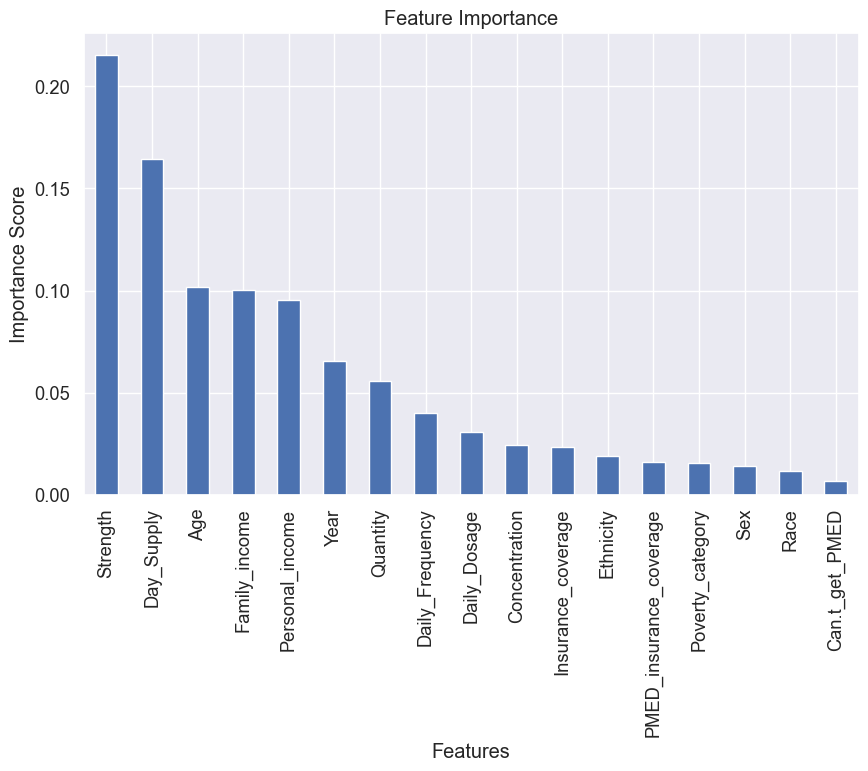

In [125]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
print("Feature Importances:\n", feature_importances)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

checking for duplicate records

In [126]:
duplicates = meps_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
meps_data = meps_data.drop_duplicates()

Number of duplicate rows: 720711


Model implementation - 2 with no duplicate records

In [127]:
X = meps_data.drop('Drug', axis=1)
y = meps_data['Drug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Training set size: (268278, 17), Testing set size: (67070, 17)
Accuracy: 0.58
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       423
           1       0.33      0.20      0.25         5
           2       1.00      1.00      1.00         1
           3       0.55      0.56      0.56       112
           4       0.38      0.50      0.43         6
           5       0.99      0.99      0.99      2170
           6       0.98      0.99      0.98       207
           7       0.14      0.14      0.14        14
           8       0.48      0.49      0.49       381
           9       0.12      0.14      0.13         7
          10       0.62      0.63      0.62       421
          11       0.50      0.33      0.40         3
          12       0.50      0.39      0.44        85
          13       0.23      0.31      0.27       172
          14       0.48      0.50      0.49      1839
          15       1.00      1.00 

/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior

Feature Importances:
 Strength                   0.218260
Day_Supply                 0.172064
Age                        0.092355
Family_income              0.089300
Personal_income            0.086792
Quantity                   0.075775
Year                       0.065319
Daily_Frequency            0.041936
Daily_Dosage               0.029820
Concentration              0.025602
Insurance_coverage         0.023255
Ethnicity                  0.017119
PMED_insurance_coverage    0.016579
Poverty_category           0.016001
Sex                        0.013082
Race                       0.011023
Can.t_get_PMED             0.005718
dtype: float64


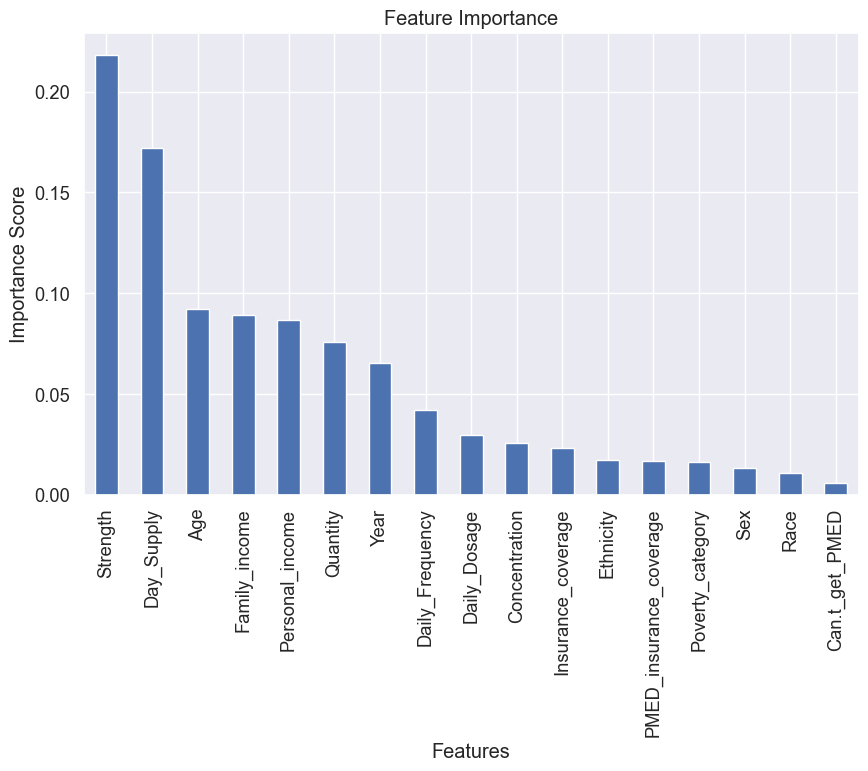

In [129]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
print("Feature Importances:\n", feature_importances)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

Checking corelation between features

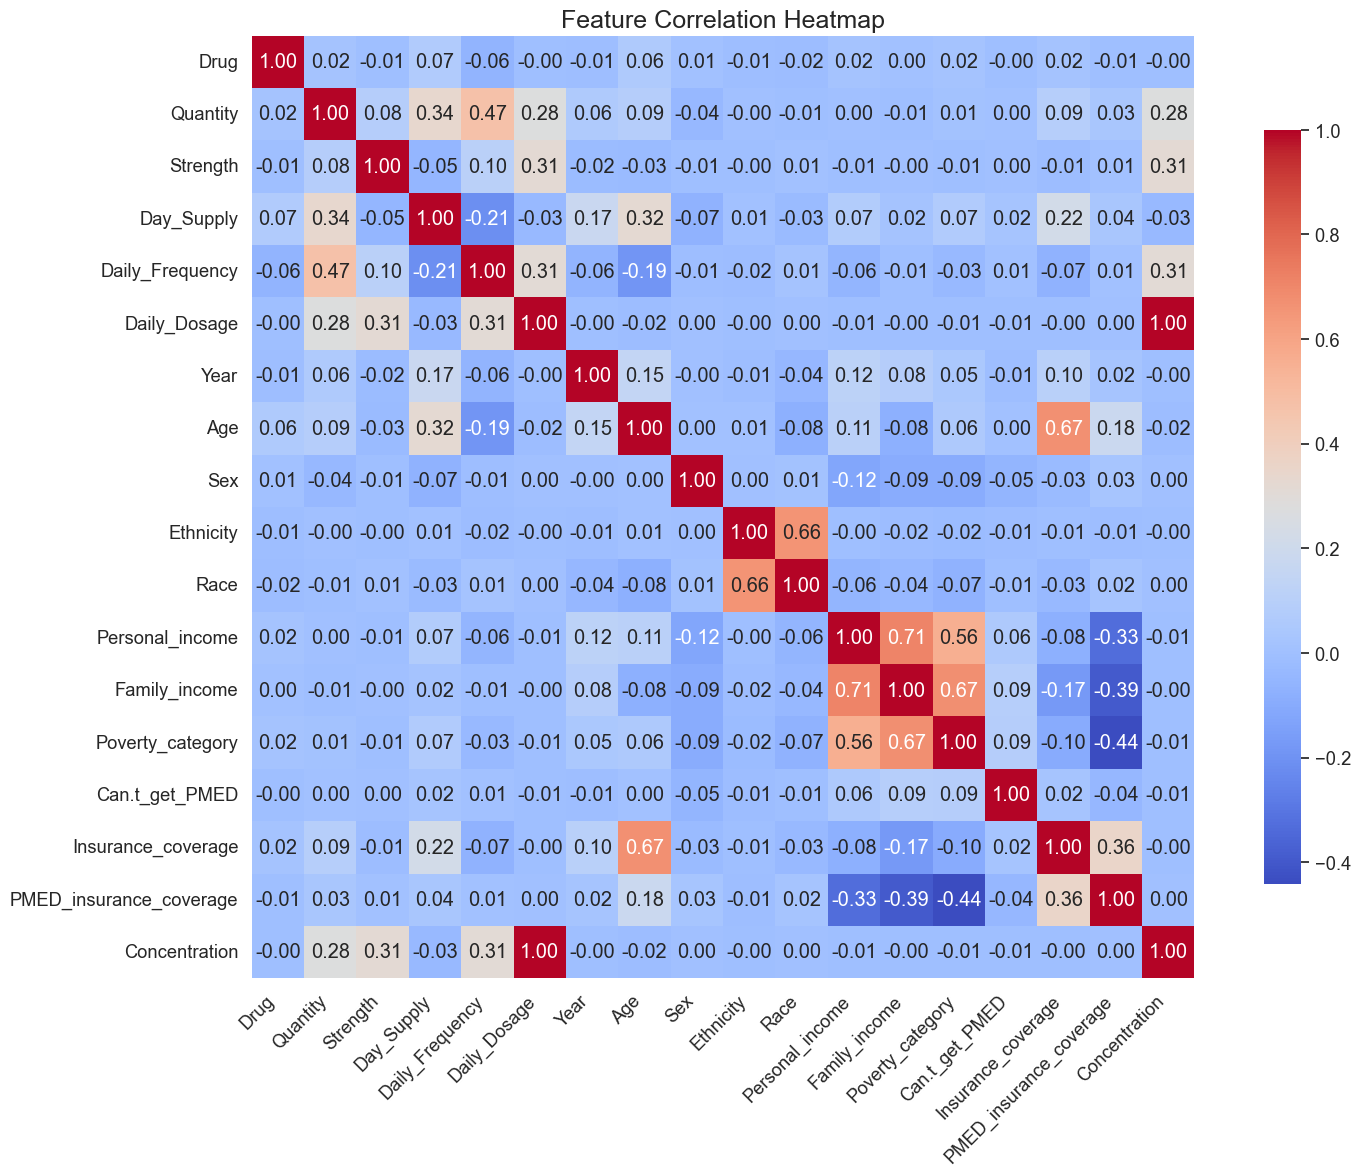

In [93]:
correlation_matrix = meps_data.corr()

plt.figure(figsize=(16, 12)) 
sns.set(font_scale=1.2)  
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar_kws={'shrink': 0.8},
    square=True
)

plt.title('Feature Correlation Heatmap', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()


Based on the above corelation graph, dropping higly corelated columns 

In [94]:
columns_to_drop = [
    'Personal_income',       # Highly correlated with Family_income
    'Poverty_category',      # Redundant with Family_income
    'Daily_Frequency',       # Correlated with Day_Supply
]
meps_data = meps_data.drop(columns=columns_to_drop)
print("Remaining columns after dropping:", meps_data.columns)

Remaining columns after dropping: Index(['Drug', 'Quantity', 'Strength', 'Day_Supply', 'Daily_Dosage', 'Year',
       'Age', 'Sex', 'Ethnicity', 'Race', 'Family_income', 'Can.t_get_PMED',
       'Insurance_coverage', 'PMED_insurance_coverage', 'Concentration'],
      dtype='object')


Model implementation - 3 after dropping columns that are highly corelated

In [95]:
X = meps_data.drop('Drug', axis=1)
y = meps_data['Drug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Training set size: (268278, 14), Testing set size: (67070, 14)
Accuracy: 0.58
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       423
           1       0.25      0.20      0.22         5
           2       1.00      1.00      1.00         1
           3       0.52      0.54      0.53       112
           4       0.33      0.50      0.40         6
           5       0.99      0.99      0.99      2170
           6       0.98      0.99      0.98       207
           7       0.15      0.14      0.15        14
           8       0.51      0.50      0.50       381
           9       0.25      0.14      0.18         7
          10       0.61      0.63      0.62       421
          11       0.50      0.33      0.40         3
          12       0.40      0.31      0.35        85
          13       0.21      0.30      0.25       172
          14       0.47      0.49      0.48      1839
          15       1.00      1.00 

/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior

In [96]:
print(meps_data.columns)

Index(['Drug', 'Quantity', 'Strength', 'Day_Supply', 'Daily_Dosage', 'Year',
       'Age', 'Sex', 'Ethnicity', 'Race', 'Family_income', 'Can.t_get_PMED',
       'Insurance_coverage', 'PMED_insurance_coverage', 'Concentration'],
      dtype='object')


In [97]:
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters found:", grid_search.best_params_)
best_model = grid_search.best_estimator_


/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


Model implementation - 4 after hyper param tuning using grid search cv

In [98]:
clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [99]:
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.67      0.72       423
           1       0.33      0.20      0.25         5
           2       1.00      1.00      1.00         1
           3       0.57      0.52      0.54       112
           4       0.25      0.33      0.29         6
           5       0.99      0.99      0.99      2170
           6       0.98      0.98      0.98       207
           7       0.00      0.00      0.00        14
           8       0.64      0.56      0.60       381
           9       0.25      0.14      0.18         7
          10       0.60      0.62      0.61       421
          11       0.00      0.00      0.00         3
          12       0.31      0.21      0.25        85
          13       0.54      0.21      0.30       172
          14       0.40      0.72      0.51      1839
          15       1.00      1.00      1.00        34
          16       0.79      0.89      0.84

/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior

Applying feature importance

Feature Importances:
 Strength                   0.219108
Day_Supply                 0.174834
Family_income              0.146321
Age                        0.111792
Quantity                   0.080746
Year                       0.074414
Daily_Dosage               0.053551
Concentration              0.037498
Insurance_coverage         0.027747
Ethnicity                  0.020413
PMED_insurance_coverage    0.019958
Sex                        0.014535
Race                       0.012400
Can.t_get_PMED             0.006682
dtype: float64


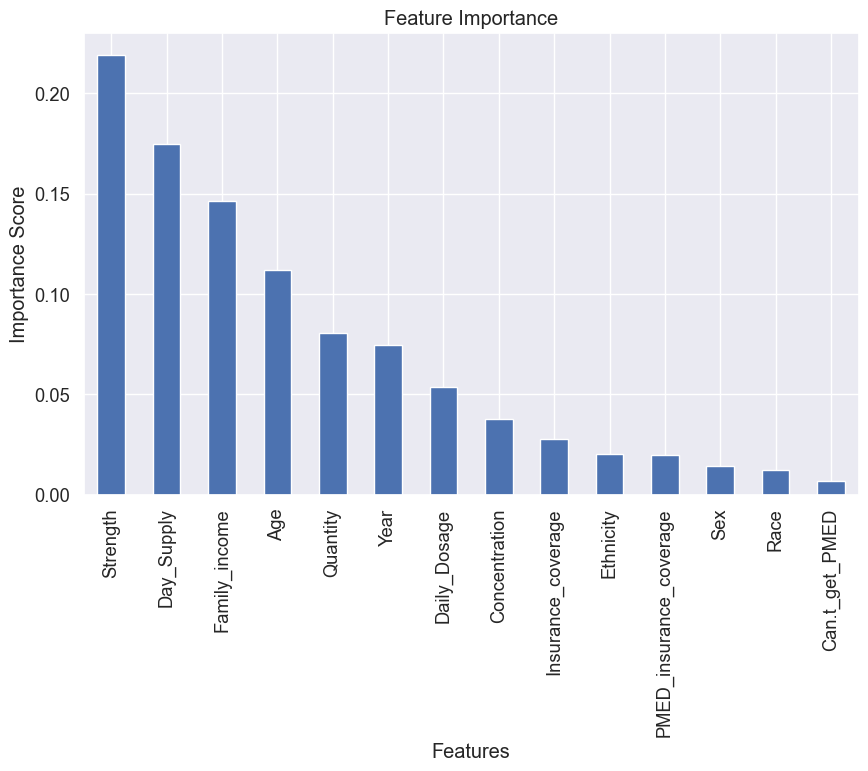

In [100]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)
print("Feature Importances:\n", feature_importances)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

droping unimportant columns

In [101]:
columns_to_drop = ['Can.t_get_PMED', 'Race', 'Sex', 'PMED_insurance_coverage']
X_train_reduced = X_train.drop(columns=columns_to_drop)
X_test_reduced = X_test.drop(columns=columns_to_drop)
print("Remaining columns after dropping:", X_train_reduced.columns)

Remaining columns after dropping: Index(['Quantity', 'Strength', 'Day_Supply', 'Daily_Dosage', 'Year', 'Age',
       'Ethnicity', 'Family_income', 'Insurance_coverage', 'Concentration'],
      dtype='object')


In [103]:
clf.fit(X_train_reduced, y_train)
y_pred_reduced = clf.predict(X_test_reduced)

print(f"Accuracy with reduced features: {accuracy_score(y_test, y_pred_reduced):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_reduced))

Accuracy with reduced features: 0.58
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72       423
           1       0.20      0.20      0.20         5
           2       1.00      1.00      1.00         1
           3       0.53      0.55      0.54       112
           4       0.38      0.50      0.43         6
           5       0.99      0.99      0.99      2170
           6       0.98      0.99      0.98       207
           7       0.17      0.14      0.15        14
           8       0.45      0.47      0.46       381
           9       0.11      0.14      0.12         7
          10       0.62      0.62      0.62       421
          11       0.50      0.33      0.40         3
          12       0.39      0.31      0.34        85
          13       0.21      0.30      0.25       172
          14       0.46      0.48      0.47      1839
          15       1.00      1.00      1.00        34
          16       0.

/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior

Basic cross validation

In [131]:
clf = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.36121962 0.46927091 0.54540033 0.56177966 0.45432316]
Mean accuracy: 0.48


Cross-Validation with Stratification

In [133]:
clf = DecisionTreeClassifier(random_state=42)
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=stratified_kf, scoring='accuracy')
print(f"Stratified cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

/Users/akhilaannireddy/Projects/sewer_project/sewerenv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Stratified cross-validation scores: [0.57963322 0.57979723 0.58039362 0.58026808 0.58201255]
Mean accuracy: 0.58


Summary :

1. Model accuracy with all the columns (person id, unnamed)- 0.91
2. removed duplicates - 0.58
3. checked corelation between features and dropped higly corelated ones - 0.58
4. applied hyper param tuning - 0.60
5. applied feature importnace and dropped unimportant features - 0.58
6. basic cross validation - 0.48 avg
7. cross validation with stratifiedkfold - 0.58 avg